In [1]:
import pylab as plt
import tqdm as tqdm
import pandas as pd
from herbie import FastHerbie
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import warnings
import pyproj
import matplotlib.patches as patches
warnings.filterwarnings('ignore')
import pickle
import datetime

In [2]:
def uv_to_earth_kyle(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dlam = m.dy_dlam
    dx_dlam = m.dx_dlam

    theta = -np.arctan2(dy_dlam, dx_dlam)

    return (
        u * np.cos(theta) - v * np.sin(theta),
        u * np.sin(theta) + v * np.cos(theta),
        theta,
    )


def uv_to_grid_kyle(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dlam = m.dy_dlam
    dx_dlam = m.dx_dlam

    theta = np.arctan2(dy_dlam, dx_dlam)

    return (
        u * np.cos(theta) - v * np.sin(theta),
        u * np.sin(theta) + v * np.cos(theta),
        theta,
    )

In [3]:
globe = ccrs.Globe(ellipse="sphere", semimajor_axis=6370000, semiminor_axis=6370000)

# map projections for WRF
''' Copied from WRF output file
                :CEN_LAT = 37.00002f ;
                :CEN_LON = -129.f ;
                :TRUELAT1 = 30.f ;
                :TRUELAT2 = 42.f ;
                :MOAD_CEN_LAT = 37.00002f ;
                :STAND_LON = -100.f ;
'''
crsproj_wrf = ccrs.LambertConformal(
    central_longitude=-100.,
    central_latitude=37.,
    standard_parallels=[30., 42.],
    globe=globe,
)
pyproj_wrf = pyproj.Proj(crsproj_wrf)

# map projections for PINACLES
lat_center = 35.00
lon_center = -123.71
proj_lon_center = -68.0
crsproj_pinacles = ccrs.LambertConformal(
    central_longitude=proj_lon_center,
    central_latitude=lat_center,
    standard_parallels=(lat_center, lat_center),
    globe=globe,
)
pyproj_pinacles = pyproj.Proj(crsproj_pinacles)


In [4]:
pc = ccrs.PlateCarree()

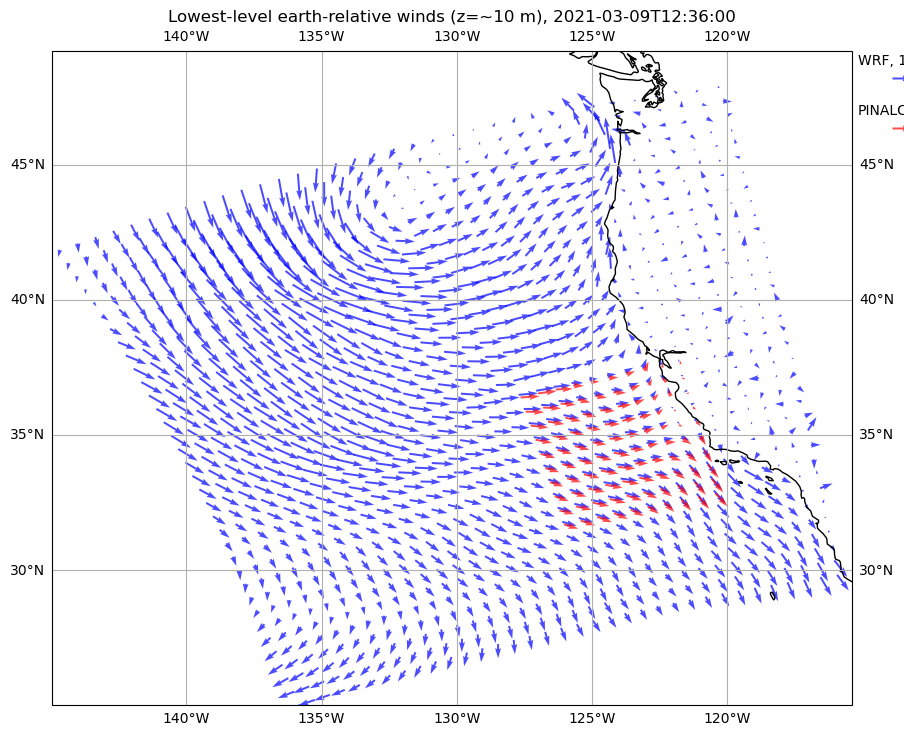

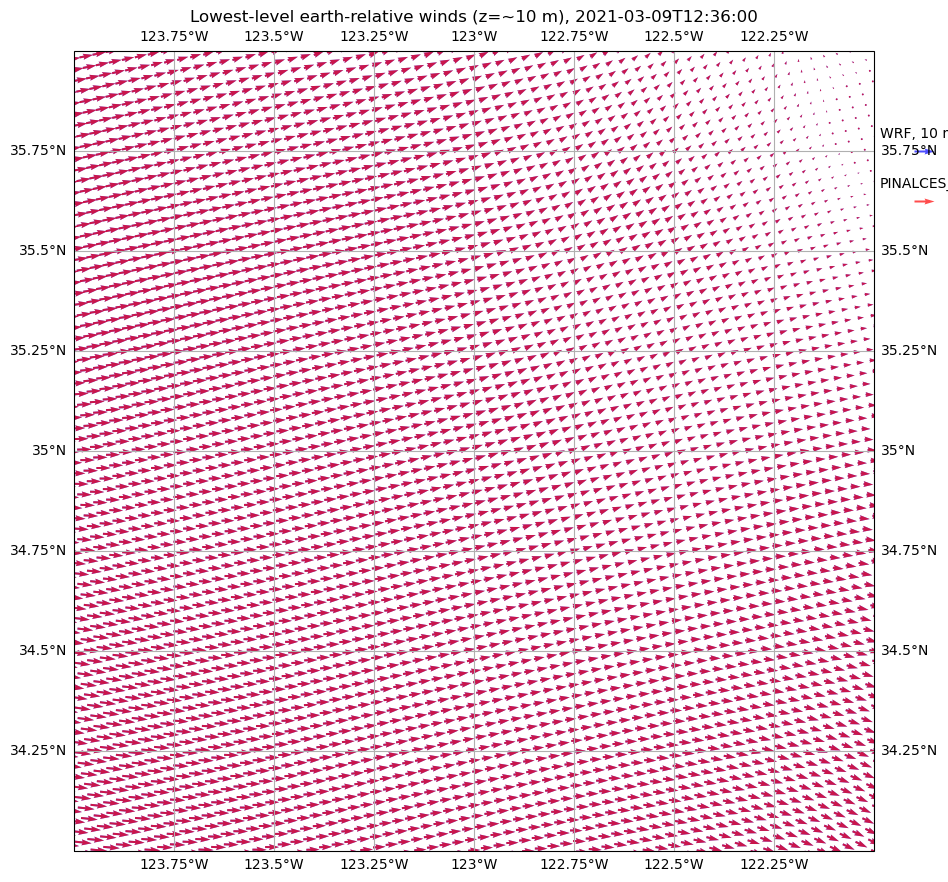

In [5]:
ds_wrf = xr.open_dataset("output_morr/wrf2pin_d01_2021-03-09_12_30_00", decode_times=False)
ds_pin = xr.open_dataset("pinacles_in.wrf/pinacles_in_2021-03-09_12_30_00.nc")
nt = 3
nz = 0 
u_wrf = (ds_wrf.U.values[nt, nz, :, 1:] + ds_wrf.U.values[nt, nz, :, :-1])*0.5
v_wrf = (ds_wrf.V.values[nt, nz, 1:, :] + ds_wrf.V.values[nt, nz, :-1, :])*0.5
lon_wrf, lat_wrf = ds_wrf.XLONG[nt,:,:], ds_wrf.XLAT[nt,:,:]
u_wrf_e, v_wrf_e, alpha_wrf = uv_to_earth_kyle(lon_wrf, lat_wrf, pyproj_wrf, u_wrf, v_wrf)
lat_pin = ds_pin.latitude
lon_pin = ds_pin.longitude
u_pin = ds_pin.U[nt, nz, :, :]
v_pin = ds_pin.V[nt, nz, :, :]
u_pin_e, v_pin_e, alpha_pin = uv_to_earth_kyle(lon_pin, lat_pin, pyproj_pinacles, u_pin, v_pin)
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_wrf.min(), lon_wrf.max(), lat_wrf.min(), lat_wrf.max()))
# d = 1 
q1 = ax.quiver(lon_wrf[::d,::d], lat_wrf[::d,::d], u_wrf_e[::d,::d], v_wrf_e[::d,::d], color='blue', scale_units='dots', scale=0.5, units='dots', width=2, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], u_pin_e[::d,::d], v_pin_e[::d,::d], color='red', scale_units='dots', scale=0.5, units='dots', width=2, alpha=0.7)
ax.set_title(f"Lowest-level earth-relative winds (z=~10 m), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
ax.quiverkey(q1, 0.9, 0.75, 10, label='WRF, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='PINALCES_IN', color='red',coordinates='figure')
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
ax.set_extent((-124, -122, 34, 36))
# ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
d = 1 
q1 = ax.quiver(lon_wrf[::d,::d], lat_wrf[::d,::d], u_wrf_e[::d,::d], v_wrf_e[::d,::d], color='blue', scale_units='dots', scale=0.5, units='dots', width=2, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], u_pin_e[::d,::d], v_pin_e[::d,::d], color='red', scale_units='dots', scale=0.5, units='dots', width=2, alpha=0.7)
ax.set_title(f"Lowest-level earth-relative winds (z=~10 m), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
ax.quiverkey(q1, 0.9, 0.75, 10, label='WRF, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='PINALCES_IN', color='red',coordinates='figure')
plt.show()

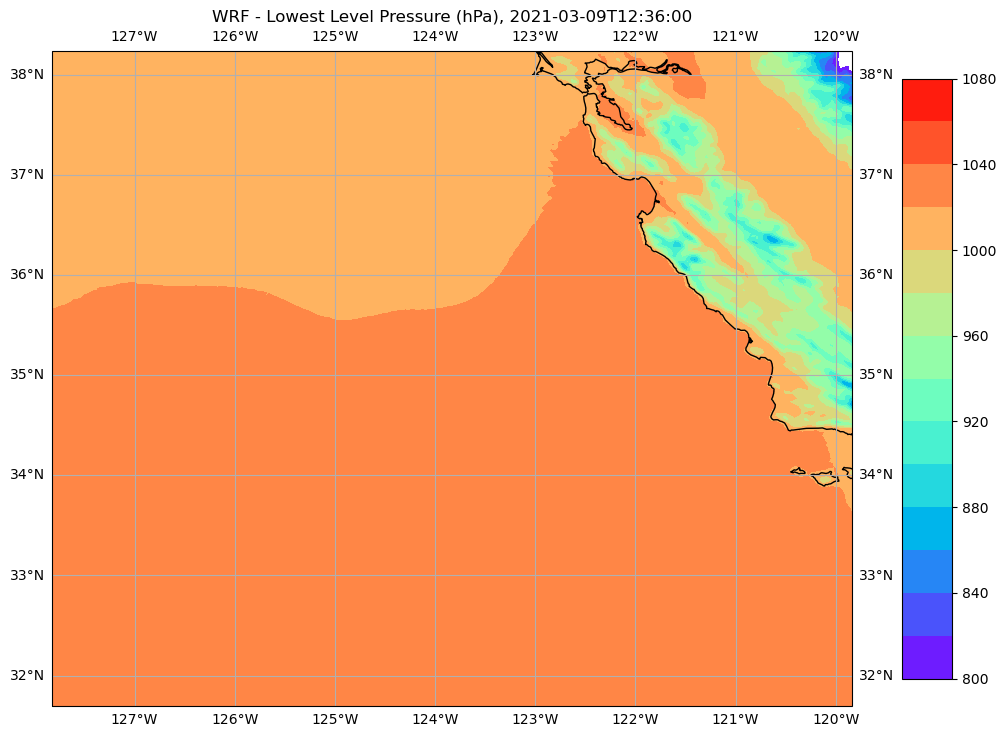

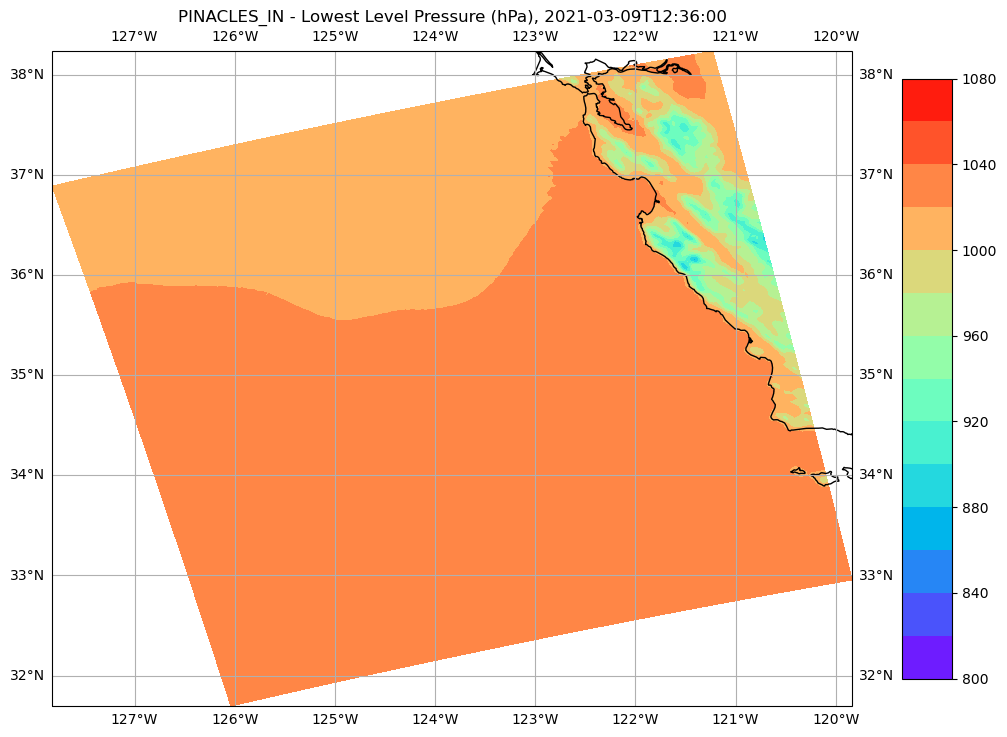

In [6]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
levels = np.arange(800, 1100, 20)
cf = ax.contourf(lon_wrf, lat_wrf, (ds_wrf.P.values + ds_wrf.PB.values)[nt, nz, :, :]*1.0e-2, levels=levels, cmap='rainbow')
ax.set_title(f"WRF - Lowest Level Pressure (hPa), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
cf = ax.contourf(lon_pin, lat_pin, ds_pin.P.values[nt, nz, :, :]*1.0e-2, levels=levels, cmap='rainbow')
ax.set_title(f"PINACLES_IN - Lowest Level Pressure (hPa), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()

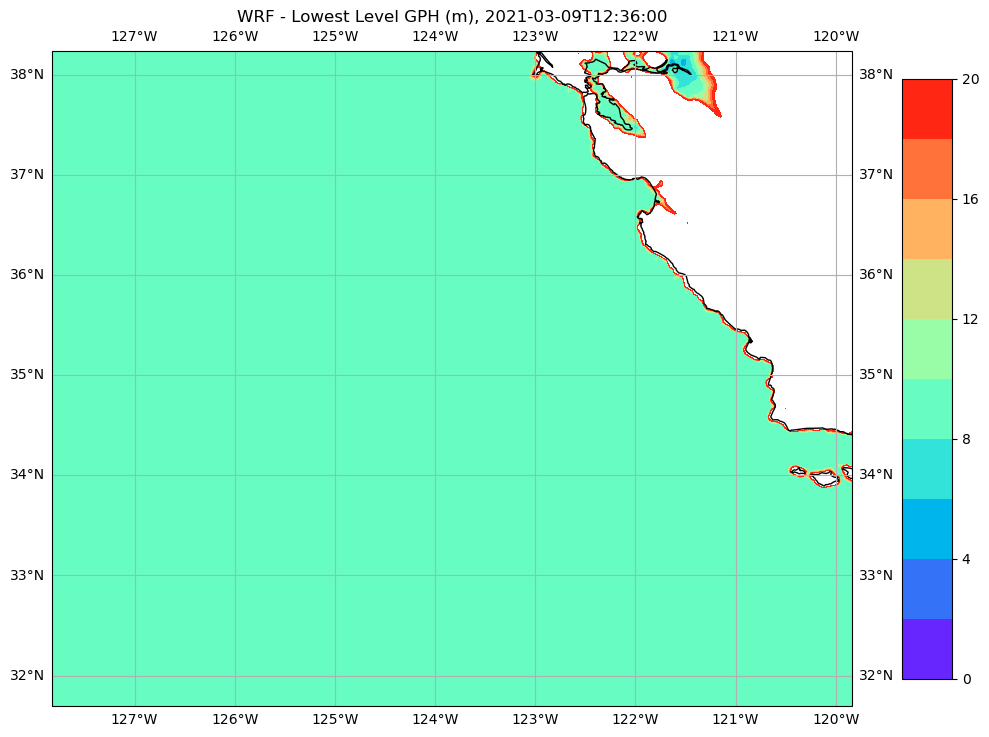

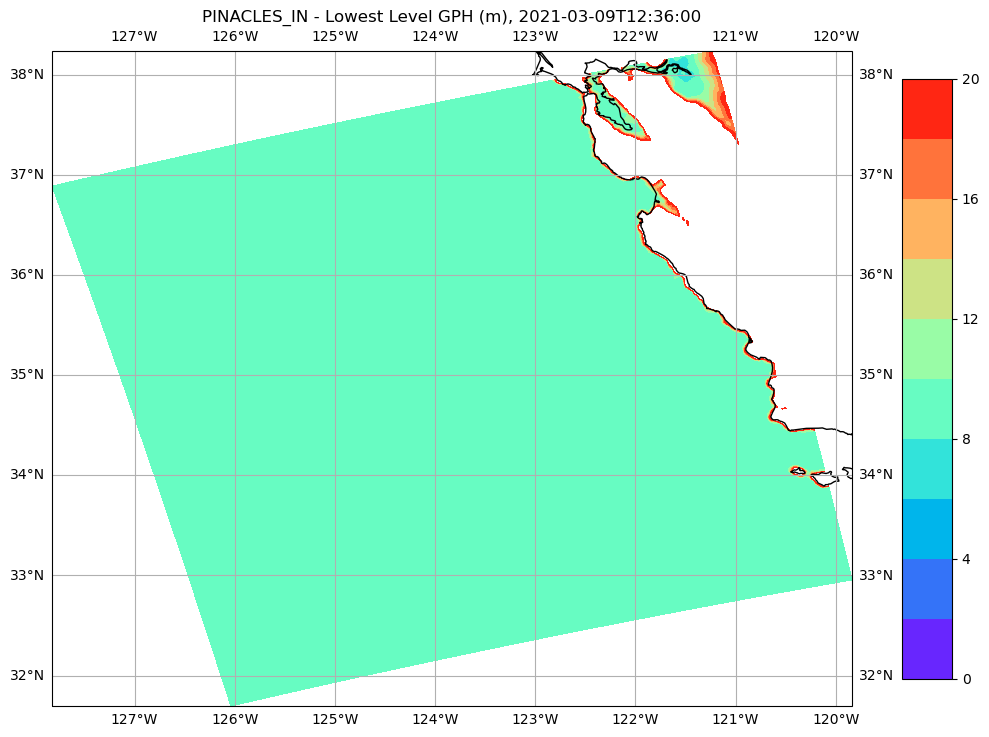

In [10]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
levels = np.arange(0, 22, 2)
# levels = None
cf = ax.contourf(lon_wrf, lat_wrf, ((ds_wrf.PH.values + ds_wrf.PHB.values)[nt, nz, :, :]+(ds_wrf.PH.values + ds_wrf.PHB.values)[nt, nz+1, :, :])*0.5/9.81, levels=levels, cmap='rainbow')
ax.set_title(f"WRF - Lowest Level GPH (m), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
cf = ax.contourf(lon_pin, lat_pin, ds_pin.Z.values[nt, nz, :, :], levels=levels, cmap='rainbow')
ax.set_title(f"PINACLES_IN - Lowest Level GPH (m), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()

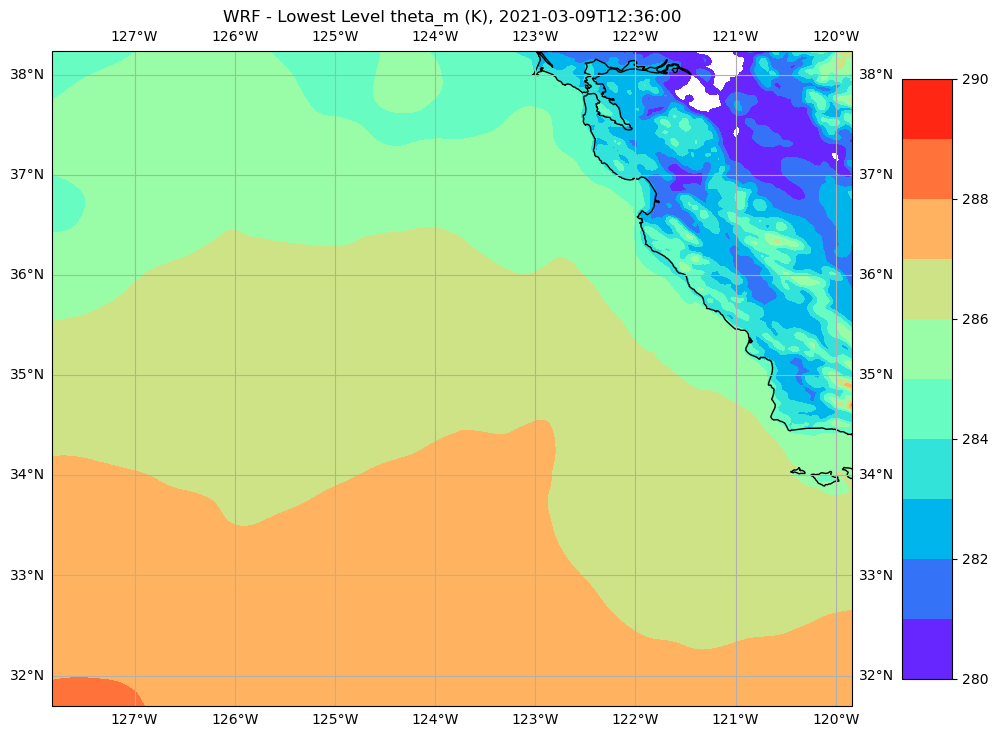

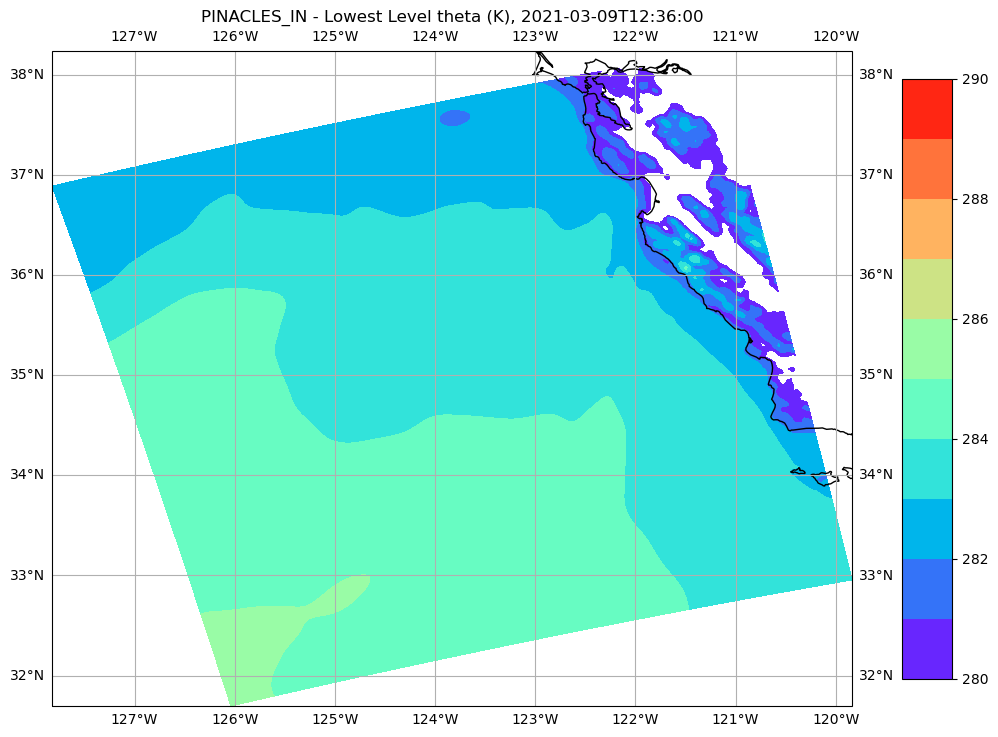

In [12]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
levels = np.arange(280, 291, 1)
# levels = None
cf = ax.contourf(lon_wrf, lat_wrf, (ds_wrf.THM.values + 300.)[nt, nz, :, :], levels=levels, cmap='rainbow')
ax.set_title(f"WRF - Lowest Level theta_m (K), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((lon_pin.min(), lon_pin.max(), lat_pin.min(), lat_pin.max()))
cf = ax.contourf(lon_pin, lat_pin, ds_pin.T.values[nt, nz, :, :], levels=levels, cmap='rainbow')
ax.set_title(f"PINACLES_IN - Lowest Level theta (K), {np.datetime_as_string(ds_pin.time.values[nt], unit='s')}")
cax = fig.add_axes((0.9, 0.15, 0.05, 0.6))
plt.colorbar(cf, cax=cax)
plt.show()